In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *

In [7]:
path = Path('../../data/results/experiment5')

In [8]:
D = 50
nn_window = 5
nn_nf = 4
frequency = 100_000
max_times = 100
total_generations = max_times * frequency + 1000

In [9]:
experiment=1


if experiment==1:
    ab = pd.read_csv(path/'dC_01.csv')['b'].values
    def fitness_func(indiv, b, t): return (indiv.data**2).sum()
    def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)
    
elif experiment==2:
    ab = pd.read_csv(path/'dC_01.csv')['b'].values
    def fitness_func(indiv, b, t): return (indiv.data**2).sum()
    def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)
elif experiment==3:
    ab=[]
    # experiment 3: dynamic fitness function (linear)
    def fitness_func(indiv, b, t): return ((indiv.data + 0.1*t)**2).sum()
    def constraint_func(indiv, b, t): return 0
    
else:
    ab=[]
# experiment 4: dynamic fitness function (x-sin(pi/2*t))^2
    def fitness_func(indiv, b, t): return ((indiv.data-np.sin(np.pi/2*t))**2).sum()
    def constraint_func(indiv, b, t): return 0

In [10]:
population = Population.new_random(dimension=D)

opt = Optimization(population, fitness_func, constraint_func, constraint_params=[ab],
                   max_times=max_times, frequency=frequency, callbacks=[OnChangeRestartPopulation])
opt.state_dict

{'gen': 0, 'evals': 0, 'time': 0, 'time_evals': 0, 'best': None}

Total time: 39:29


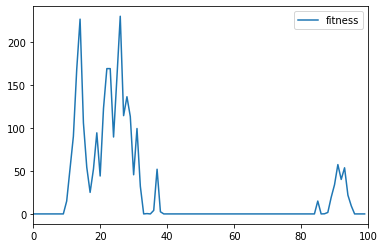

In [11]:
opt.run(total_generations, update_each=1)

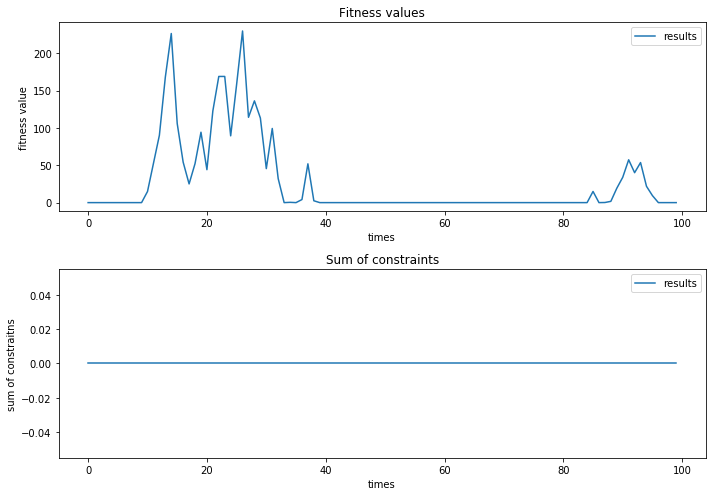

In [12]:
opt.recorder.plot();

In [13]:
df = pd.DataFrame({'fitness':opt.recorder.best_times_fitness, 'sum_constraints':opt.recorder.best_times_constraints})
df.head()

,fitness,sum_constraints
0,2.117430e-05,0.0
1,6.057739e-07,0.0
2,2.286629e-07,0.0
3,2.286629e-07,0.0
4,2.286629e-07,0.0


In [14]:
path.mkdir(parents=True, exist_ok=True)
df.to_csv(path/'best_known.csv', index=False)